<center><b><font size=6>Supervised learning – classification<b><center>

This notebook implements the supervised learning component of the SSH Shell Attack session project. The goal is to classify attack session tactics based on the provided dataset.

0. **Install Dependencies**
1. **Data Splitting**
2. **Baseline Model Implementation**
3. **Hyperparameter Tuning**
4. **Result Analysis**  
5. **Feature Experimentation**

<center><b><font size=5>Install Dependencies<b><center>

In [272]:
!python ../scripts/install_dependencies.py section2

Installing common packages: pandas, pyarrow
Installing Section 2 packages: matplotlib, seaborn, scikit-learn


In [273]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import sys
sys.path.append('../')

from scripts.data_processing import sampling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

<center><b><font size=5>Data Splitting<b><center>

Split the dataset into training and testing sets.

"Perform a split to segment the dataset into training and test dataset.
If you want to standardize your dataset, fit the scaler on training set and transforming both training
and test. Notice that the sklearn implementation of tf-idf already performs the standardization."

**Steps:**

- Data Loading
- Data Splitting
- Multi-Label Transformation
- Summary

### Load the dataset

- Loads the dataset from a Parquet file into a Pandas DataFrame.

In [274]:
# Dataset intero
SSH_Attacks = pd.read_parquet("../data/processed/ssh_attacks_decoded.parquet")
#SSH_Attacks

In [275]:
SSH_Attacks_bow_sampled = pd.read_parquet("../data/processed/BOW_DATASETS/ssh_attacks_bow_sampled.parquet")
#SSH_Attacks_bow_sampled

In [276]:
SSH_Attacks_tfidf_sampled = pd.read_parquet("../data/processed/TFIDF_DATASETS/ssh_attacks_tfidf_sampled.parquet")
#SSH_Attacks_tfidf_sampled

### Data Splitting

- Define Features (X) and Labels (y)
- Split Data into Training and Testing Sets
- Preprocess Text Data
- Vectorize Text with TF-IDF


_Suggestions:_

- _point 1. Validate that full_session and Set_Fingerprint do not have null values using: print(X.isnull().sum(), y.isnull().sum())_
- _point 2. Stratify the split if the label distribution is imbalanced using: train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)_
- _point 2. Check the distribution of labels in training and test sets._
- _point 3. Add a basic cleaning step if the text contains unwanted characters or casing._
- _point 4. Explore hyperparameters like ngram_range, min_df, and max_df to see their effect on performance._
- _point 4. Use stop_words='english' to remove common but non-informative words._

In [277]:
# Campiona il 5% del dataset
SSH_Attacks_sampled = sampling(SSH_Attacks, 2, 0.05)

# Separazione delle caratteristiche (X) e del target (y)
X = SSH_Attacks_sampled['full_session']  # Text data
y = SSH_Attacks_sampled['Set_Fingerprint']  # Multi-label target

# Ensure a 70/30 split while maintaining reproducibility (random_state=42).
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Convert to strings to ensure compatibility with TfidfVectorizer
X_train = X_train.astype(str)
X_test = X_test.astype(str)

# Vectorize the text data using TF-IDF (standardization is included in TF-IDF by default)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Controllo delle dimensioni dei dati vettorizzati
print(f"Train set TF-IDF shape: {X_train_tfidf.shape}")
print(f"Test set TF-IDF shape: {X_test_tfidf.shape}")

Train set TF-IDF shape: (8172, 64)
Test set TF-IDF shape: (3503, 64)


### Multi-Label Transformation

- Transform Labels to Binary Format


_Suggestions:_

- _Check for any inconsistencies in label transformation: print(y_train_binary.head(), y_test_binary.head())_
- _Verify that `mlb.classes` matches the expected categories._

In [278]:
# Fit the MultiLabelBinarizer on the training set labels only
mlb = MultiLabelBinarizer()
mlb.fit(y_train)

# Transform the training and test labels into binary matrices
y_train_binary = pd.DataFrame(mlb.transform(y_train), columns=mlb.classes_, index=y_train.index)
y_test_binary = pd.DataFrame(mlb.transform(y_test), columns=mlb.classes_, index=y_test.index)


### Summary

- Ensures the processed data is correctly prepared for modeling.


_Suggestions:_

- _Check the sparsity of X_train_tfidf and X_test_tfidf: print("Train Sparsity:", (X_train_tfidf.nnz / np.prod(X_train_tfidf.shape)) * 100) print("Test Sparsity:", (X_test_tfidf.nnz / np.prod(X_test_tfidf.shape)) * 100)_

In [279]:
# Print basic info about the processed data
print("\nProcessed Training set size:", len(X_train))
print("\nProcessed Testing set size:", len(X_test))
print("\nShape of y_train_binary:", y_train_binary.shape)
print("\nShape of y_test_binary:", y_test_binary.shape)
print("\nClasses:", mlb.classes_)


Processed Training set size: 8172

Processed Testing set size: 3503

Shape of y_train_binary: (8172, 7)

Shape of y_test_binary: (3503, 7)

Classes: ['Defense Evasion' 'Discovery' 'Execution' 'Harmless' 'Impact' 'Other'
 'Persistence']


<center><b><font size=5>Baseline Model Implementation<b><center>

Train at least two ML models and evaluate their performance.

"Choose at least 2 ML methods, and perform the model training, with default parameter
configuration, evaluating the performance on both training and test set. Output the confusion
matrix and classification report. Do you observe overfitting or under-fitting? Which model
generates the best performance?"

**Steps:**

- Choose different ML models (e.g., Logistic Regression and Random Forest).
- Logistic Regression - Training and Evaluation.
- Random Forest - Training and Evaluation.
- Support Vector Machine (SVM) - Training and Evaluation.
- Compare performance and check for overfitting/underfitting.

### Choose and initialize models

- text

In [287]:
# Initialize models with default parameters
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),  # Logistic Regression model
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42), # Random Forest with 100 estimators
    "SVM": SVC(kernel='linear', random_state=42)                                # Support Vector Machine with linear kernel
}

# Store results for comparison
model_results = {}


In [288]:
def train_and_evaluate(model, model_name, X_train, X_test, y_train_binary, y_test_binary):
    """
    Train a given model for each label and evaluate its performance.
    
    Args:
        model: An initialized ML model.
        model_name: Name of the model (string).
        X_train, X_test: TF-IDF-transformed training and test data.
        y_train_binary, y_test_binary: Binary label data for training and testing.
    
    Returns:
        results: A dictionary containing classification reports and confusion matrices for all labels.
    """
    results = {}
    
    # Create an empty DataFrame to store predictions for multilabel compatibility
    y_pred = pd.DataFrame(index=y_test_binary.index, columns=y_test_binary.columns)
    
    # Configura la griglia di subplots per la matrice di confusione
    num_labels = len(y_train_binary.columns)
    num_cols = 3  # Numero di colonne nella griglia
    num_rows = (num_labels + num_cols - 1) // num_cols  # Calcola il numero di righe
    
    # Initialize the plot with a grid of subplots (3 rows, 3 columns)
    fig, axes = plt.subplots(3, 3, figsize=(18, 14))  # Adjusted figsize for better spacing
    axes = axes.flatten()  # Flatten to make it easier to access individual axes
    
    # Train and evaluate for each label
    for i, label in enumerate(y_train_binary.columns):
        
        print(f"\n{'='*69}\n  TRAINING FOR LABEL: {label} ({model_name})\n{'='*69}\n")
        
        # Train the model for the current label
        model.fit(X_train, y_train_binary[label])
        
        # Save predictions for both training and test set
        y_train_pred = model.predict(X_train)
        y_pred[label] = model.predict(X_test)
        
        # Store the predictions for the current label
        results[label] = {
            "train_predictions": y_train_pred,
            "test_predictions": y_pred[label],
        }
        
        # Generate and store classification report
        report = classification_report(
            y_test_binary[label], 
            y_pred[label], 
            zero_division=0, # To avoid the warning for precision and F-score.
        )
        results[label]["classification_report"] = report
        
        # Display classification report
        print(f"\nClassification Report for {label}:\n")
        print(report)
        
        # Generate and display confusion matrix
        print(f"Confusion Matrix for {label}:\n")
        cm = confusion_matrix(y_test_binary[label], y_pred[label])
        results[label]["confusion_matrix"] = cm
        
        # Plot the confusion matrix with improved aesthetics
        ax = axes[i]  # Access the i-th subplot
        
        sns.set(font_scale=1.3)  # Adjust font size for better readability
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='coolwarm', cbar=True, 
            xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"],
            annot_kws={"size": 14, "weight": 'bold'}, linewidths=1.2, linecolor='gray', ax=ax
        )
        
        ax.set_title(f"Confusion Matrix for {label} - {model_name}", fontsize=15, weight='bold')
        ax.set_ylabel('True Label', fontsize=15)
        ax.set_xlabel('Predicted Label', fontsize=15)
        
        # Customize tick params for readability
        ax.tick_params(axis='both', labelsize=15)
        
        # Set axis labels in a larger font and remove unnecessary gridlines
        ax.yaxis.set_tick_params(width=1.2)
        ax.xaxis.set_tick_params(width=1.2)
    
    # Remove the extra empty subplot (if any)
    for j in range(num_labels, len(axes)):
        fig.delaxes(axes[j])  # Delete the last empty axis if there are fewer than 9 labels

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
    
    return results


### Logistic Regression

- Training
- Evaluation (confusion matrix and classification report)


Training and Evaluating: Logistic Regression

  TRAINING FOR LABEL: Defense Evasion (Logistic Regression)


Classification Report for Defense Evasion:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3229
           1       0.99      0.95      0.97       274

    accuracy                           1.00      3503
   macro avg       0.99      0.97      0.98      3503
weighted avg       1.00      1.00      1.00      3503

Confusion Matrix for Defense Evasion:


  TRAINING FOR LABEL: Discovery (Logistic Regression)


Classification Report for Discovery:

              precision    recall  f1-score   support

           0       1.00      0.53      0.70        15
           1       1.00      1.00      1.00      3488

    accuracy                           1.00      3503
   macro avg       1.00      0.77      0.85      3503
weighted avg       1.00      1.00      1.00      3503

Confusion Matrix for Discovery:


  TRAINING FOR LABEL: Exe

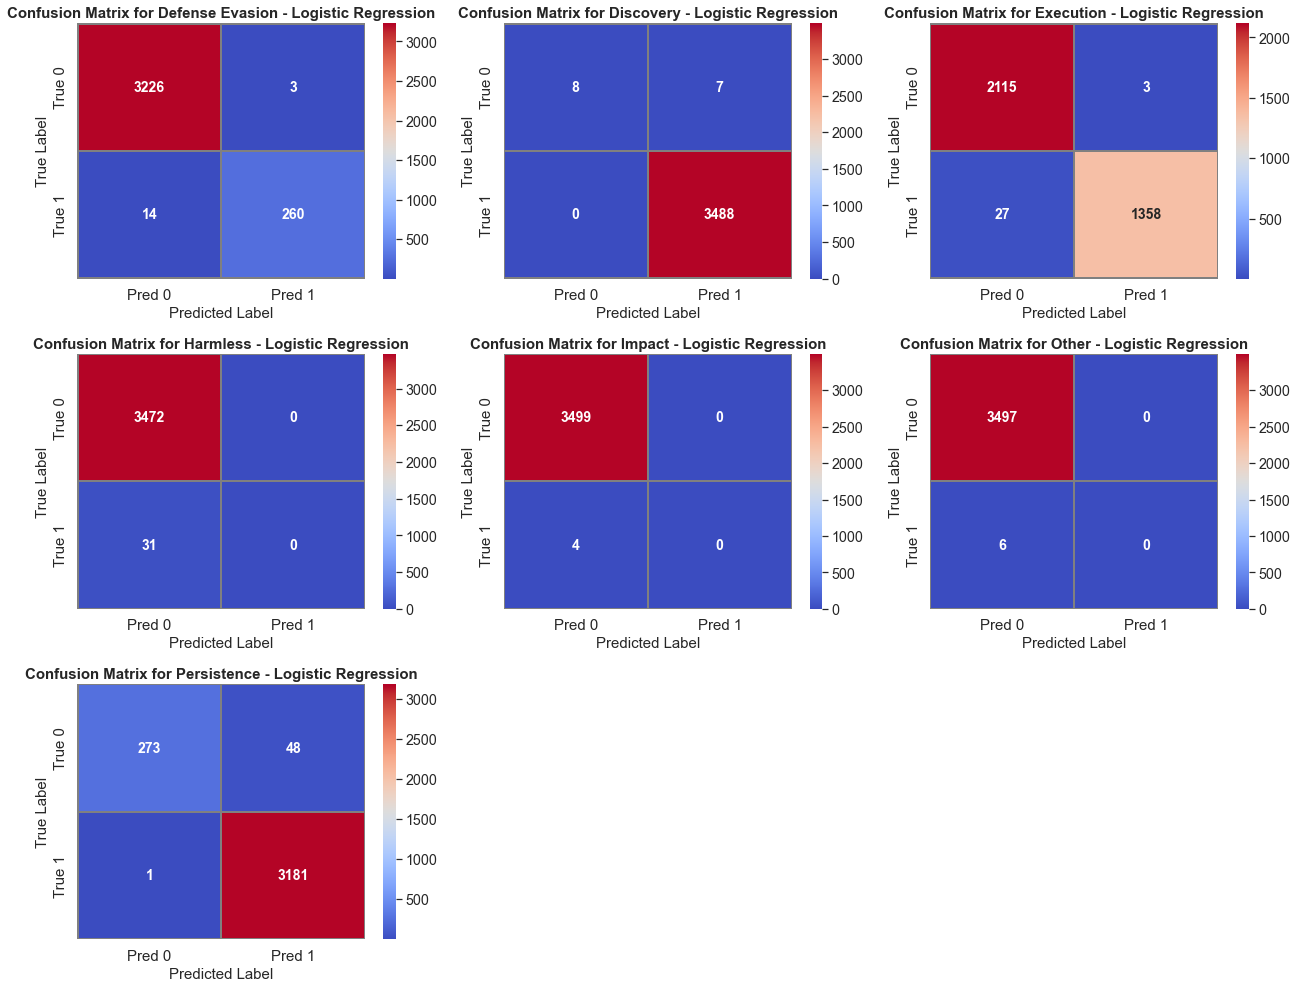

In [289]:
# Train and evaluate Logistic Regression
model_name = "Logistic Regression"
model = models[model_name]

print(f"\nTraining and Evaluating: {model_name}")

model_results[model_name] = train_and_evaluate(
    model, model_name, X_train_tfidf, X_test_tfidf, y_train_binary, y_test_binary
)

### Random Forest

- Training
- Evaluation (confusion matrix and classification report)


Training and Evaluating: Random Forest

  TRAINING FOR LABEL: Defense Evasion (Random Forest)


Classification Report for Defense Evasion:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3229
           1       0.99      0.95      0.97       274

    accuracy                           1.00      3503
   macro avg       0.99      0.98      0.98      3503
weighted avg       1.00      1.00      1.00      3503

Confusion Matrix for Defense Evasion:


  TRAINING FOR LABEL: Discovery (Random Forest)


Classification Report for Discovery:

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        15
           1       1.00      1.00      1.00      3488

    accuracy                           1.00      3503
   macro avg       0.92      1.00      0.95      3503
weighted avg       1.00      1.00      1.00      3503

Confusion Matrix for Discovery:


  TRAINING FOR LABEL: Execution (Random For

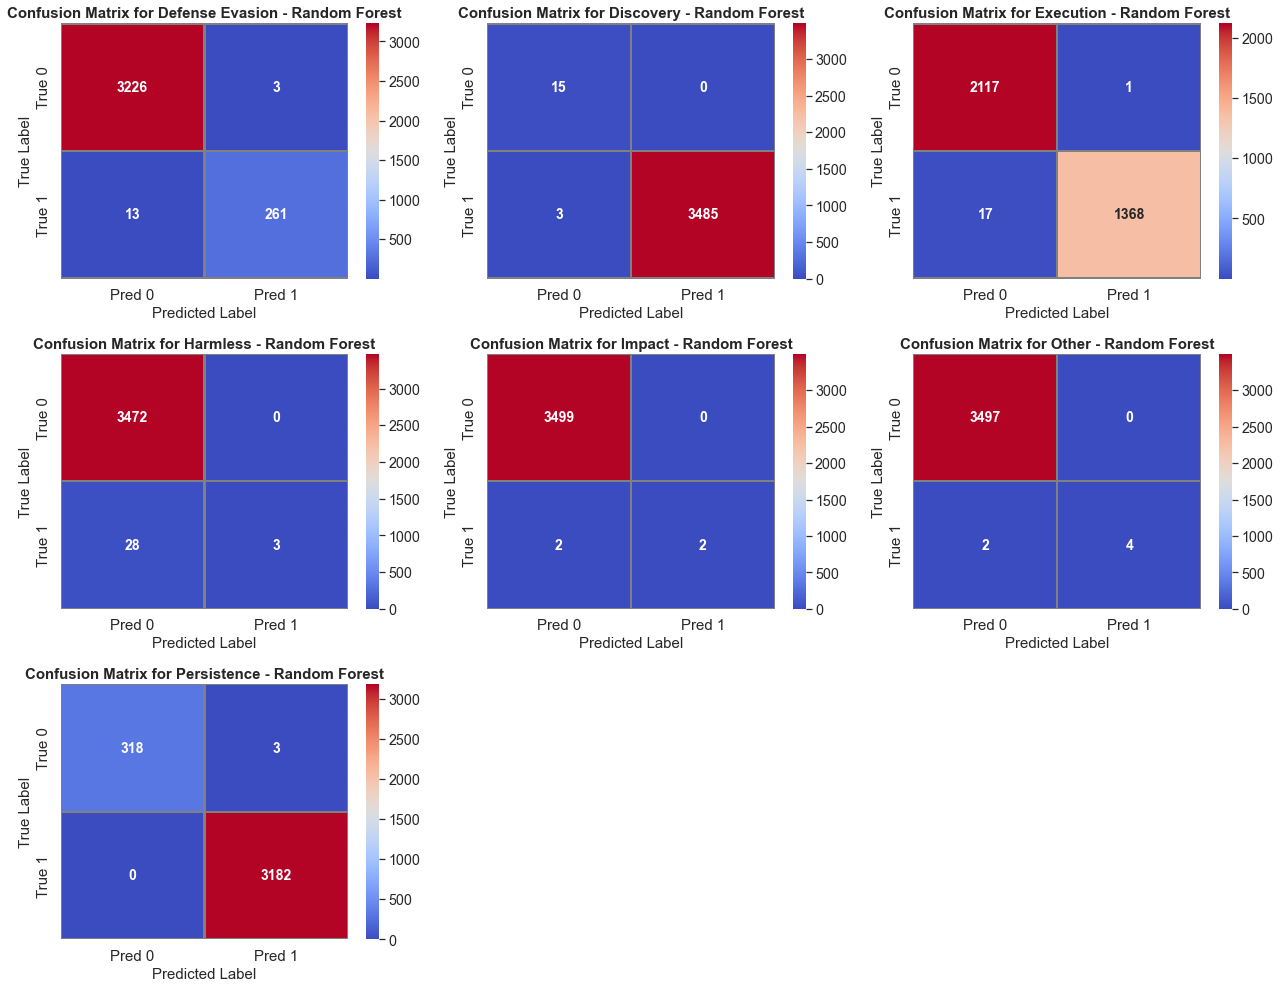

In [290]:
# Train and evaluate Random Forest
model_name = "Random Forest"
model = models[model_name]

print(f"\nTraining and Evaluating: {model_name}")

model_results[model_name] = train_and_evaluate(
    model, model_name, X_train_tfidf, X_test_tfidf, y_train_binary, y_test_binary
)

### Support Vector Machine (SVM)

- Training
- Evaluation (confusion matrix and classification report)


Training and Evaluating: SVM

  TRAINING FOR LABEL: Defense Evasion (SVM)


Classification Report for Defense Evasion:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3229
           1       0.99      0.95      0.97       274

    accuracy                           1.00      3503
   macro avg       0.99      0.97      0.98      3503
weighted avg       1.00      1.00      1.00      3503

Confusion Matrix for Defense Evasion:


  TRAINING FOR LABEL: Discovery (SVM)


Classification Report for Discovery:

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       1.00      1.00      1.00      3488

    accuracy                           1.00      3503
   macro avg       0.93      0.90      0.91      3503
weighted avg       1.00      1.00      1.00      3503

Confusion Matrix for Discovery:


  TRAINING FOR LABEL: Execution (SVM)


Classification Report for Executi

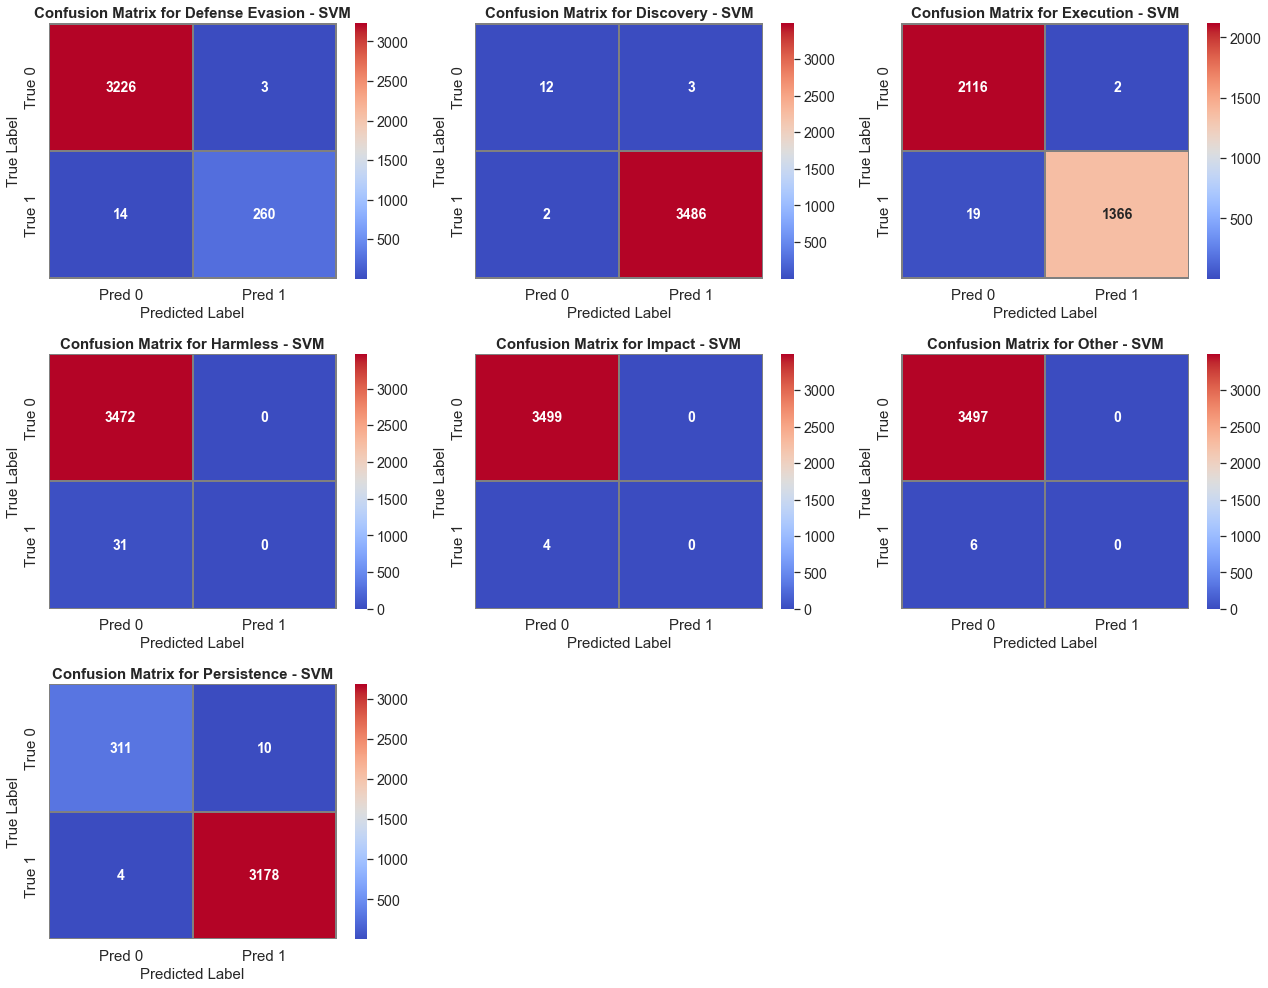

In [291]:
# Train and evaluate SVM
model_name = "SVM"
model = models[model_name]

print(f"\nTraining and Evaluating: {model_name}")

model_results[model_name] = train_and_evaluate(
    model, model_name, X_train_tfidf, X_test_tfidf, y_train_binary, y_test_binary
)

### Compare performances

"Do you observe overfitting or under-fitting? Which model generates the best performance?"

- text
- text

In [314]:
# Function to calculate and display performance metrics
def compare_performances(model_results, X_train, X_test, y_train_binary, y_test_binary):
    """
    Confronta le performance di più modelli utilizzando accuratezza, precisione, recall e F1-score.
    
    Args:
        model_results: Un dizionario dei risultati della funzione `train_and_evaluate`.
        X_train, X_test: Dati di addestramento e test.
        y_train_binary, y_test_binary: Etichette binarie per addestramento e test.
    
    Returns:
        Un DataFrame con i risultati del confronto per i modelli.
    """
    comparison = []
    
    # Iterate through the results of each model
    for model_name, results in model_results.items():
        model = models[model_name]  
        #print(f"\n{'#'*44}\nPerformance Summary for {model_name}\n{'#'*44}")
        
        # Extract predictions and evaluate on training set
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Se le predizioni sono unidimensionali, espandile per adattarle alla forma delle etichette binarie
        if y_train_pred.ndim == 1:
            y_train_pred = y_train_pred[:, np.newaxis]
        if y_test_pred.ndim == 1:
            y_test_pred = y_test_pred[:, np.newaxis]
        
        # Se il numero di colonne delle predizioni non corrisponde al numero di colonne delle etichette binarie
        # aggiungi colonne (ad esempio per la classificazione multilabel)
        if y_train_pred.shape[1] != y_train_binary.shape[1]:
            y_train_pred = np.hstack([y_train_pred] * y_train_binary.shape[1])
        if y_test_pred.shape[1] != y_test_binary.shape[1]:
            y_test_pred = np.hstack([y_test_pred] * y_test_binary.shape[1])
        
        # Converti le predizioni in DataFrame
        y_train_pred = pd.DataFrame(y_train_pred, columns=y_train_binary.columns, index=y_train_binary.index)
        y_test_pred = pd.DataFrame(y_test_pred, columns=y_test_binary.columns, index=y_test_binary.index)

        # Calcola le metriche (accuratezza, precisione, recall, F1-score, ecc.)
        train_accuracy = (y_train_pred == y_train_binary).mean().mean()  # Media su tutte le etichette
        test_accuracy = (y_test_pred == y_test_binary).mean().mean()    # Media su tutte le etichette
        
        # Memorizza i risultati per il confronto
        comparison.append({
            "Model": model_name,
            "Train Accuracy": train_accuracy,
            "Test Accuracy": test_accuracy,
        })
    
    # Converti la lista di dizionari in un DataFrame per un confronto più facile
    comparison_df = pd.DataFrame(comparison)
    
    return comparison_df


In [315]:
# Compara i modelli
performance_comparison = compare_performances(model_results, X_train_tfidf, X_test_tfidf, y_train_binary, y_test_binary)

# Visualizza i risultati
performance_comparison.sort_values(by="Test Accuracy", ascending=False)


,Model,Train Accuracy,Test Accuracy
1,Random Forest,0.386476,0.383182
2,SVM,0.386074,0.383141
0,Logistic Regression,0.379187,0.375678


<center><b><font size=5>Hyperparameter Tuning<b><center>

Fine-tune the hyperparameters of the ML models using cross-validation.

"Tune the hyper-parameters of the models through cross-validation. How do performance vary?"

**Steps:**

TO BE CHECKED

- Use GridSearchCV or RandomizedSearchCV to tune hyperparameters.
- Evaluate the performance of the tuned models.
- Compare the results with baseline performance.

### text

- text
- text

### text

- text
- text

### text

- text
- text

<center><b><font size=5>Result Analysis<b><center>

Analyze and summarize the results for each intent.

"Comments on the results for each on the intents."

**Steps:**

- Compare confusion matrices and classification reports.
- Highlight trends and insights for each intent.
- Summarize findings and discuss implications.

### text

- text
- text

### text

- text
- text

### text

- text
- text

<center><b><font size=5>Feature Experimentation<b><center>

Explore the impact of different features on model performance.

"Explore the possible features: try combining features differently, e.g., does tf-idf improve or worsen
performance? Think about the problem and summarize the ways you have tried (even those that
did not work)."

**Steps:**

- Experiment with feature combinations (e.g., adding temporal features).
- Observe performance changes with each combination.
- Document successful and unsuccessful experiments.

### text

- text
- text

### text

- text
- text

### text

- text
- text